# A Quantum Auto-Encoder based on Parametric Quantum Circuit for anomaly detection of MNIST images
## Tutorial - Hands-on ##

**Version:** V3.1 <p>
**Authors:** Stefano Giagu <stefano.giagu@uniroma1.it>


**Scope:**: learn how to design a simple variational PQC and train it for a anomaly detection task using the [pennylane](https://pennylane.ai/) platform with [pytorch](https://pytorch.org/) backend

**Libraries:** numpy, matplotlib, pennylane, torch

In [ ]:
# only needed on google colab
#!pip install pennylane-lightning-gpu

In [ ]:
# import needed libraries
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["WORLD_SIZE"] = "1"

from time import time
from tqdm import tqdm

import torch
from torch.autograd import Variable
import pennylane as qml
from pennylane import numpy as np
print('Torch version: ', torch.__version__)
print('Pennylane version: ', qml.__version__)

In [ ]:
# check if GPU is available
# Note: the example can also be run on CPU w/o problems

if torch.cuda.is_available():
  print('Number of available GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
  !nvidia-smi
else:
  print('No GPU available')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# check Pennylane software stack
qml.about()

In [ ]:
# download datasets
# this a preprocessed dataset with MNIST 0 and 1 pixels, dowinsized to 8x8 pixels and properly normalized in [0,1]

# normal data:    MNIST digit 0
# anomalous data: MNIST digit 1

!wget http://giagu.web.cern.ch/giagu/CERN/standard_data.npy
!wget http://giagu.web.cern.ch/giagu/CERN/anomalous_data.npy

In [ ]:
# Load data
normal_data_np = np.load("standard_data.npy")
anomalous_data_np = np.load("anomalous_data.npy")
print(normal_data_np.shape)
print(anomalous_data_np.shape)

In [ ]:
# Visualize data

# Plot the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))

ax1.imshow(np.reshape(normal_data_np[0], (8,8)), cmap="gray")
ax1.set_title('normal sample')
ax1.axis('off')

ax2.imshow(np.reshape(anomalous_data_np[4], (8,8)), cmap="gray")
ax2.set_title('anomalous sample')
ax2.axis('off')

plt.show()

In [ ]:
# Define train set size, the rest will be used for test
train_size = 5000

train_set = torch.tensor(normal_data_np[0:train_size])
normal_data_test = torch.tensor(normal_data_np[train_size:])
anomalous_data_test = torch.tensor(anomalous_data_np)

print("Len train set: ", len(train_set))
print("Len test set: ", len(normal_data_test))

**QAE architecture:**

In [ ]:
from IPython.display import Image
Image('http://giagu.web.cern.ch/giagu/CERN/QAE.png', width=700)

We need to implement and train only the encoder part as the decoder will be the transpose conjugate of the encoder. To train the encoder only we need just to create a loss that force the compressed qubits to be -1. This can be done by measuring for each qubit the expected value of a PauliZ operator on each qubit, (is +1 for |0> and -1 for |1>, and minimize the expected value wrt the parameters of the circuit.

In [ ]:
# Encoder Circuit to be implemented
from IPython.display import Image
Image('http://giagu.web.cern.ch/giagu/CERN/QAE2.png', width=1200)

In [ ]:
# Define a quantum device (eg the number of qubits in the circuit)

NUM_QUBITS = 6 # we need 6 quibit to encode 64 pixels (8x8=64=2^6)

# define the quantum device:
dev = qml.device("default.qubit", wires=NUM_QUBITS) #"default.qubit" is the default pennylane differentiable quantum device simulator that is capable of backprop derivatives

# definition of the quantum parametric circuit for the encoder architecture
# the circuit ansatz is made by n_layers of the same unitary block made of a 3 parametric rotations gates(along X, Y and Z) in the block sphere for each qubit, folloeed by a ladder of CNOT
# gates to entangle the qubits, the final rotation applys only on some of the qubits that are the one that will be discarded (compressed)


# helper function defining the quantum circuit for the encoder architecture
def encoder_architecture(params, n_layers, n_qubits, q_compression):
  index = 0
  for i in range(n_layers):

      # Rotation layer
      # to be implemented ...

      # Entangling layer
      # to be implemented ....

  # Final rotations on the discarded (compressed) qubits
  for j in range(q_compression):
      # to be implemented ...

# Quantum encoder pipeline
@qml.qnode(dev, interface='torch')
def encoder(params, state, return_state=False, n_layers = 3, n_qubits = 6, q_compression = 3):

    # Prepare initial state (ok in simulation, allows to skip quantum encoding of the classical data,
    # requires the input to be pre-normalized as a quantum state)
    qml.QubitStateVector(state, wires=range(n_qubits))

    # Real quantum encoding (using amplitude encoding). If you want to use it comment previous line and uncomment this ...
    #qml.AmplitudeEmbedding(features=state, wires=range(n_qubits))

    # Quantum circuit
    encoder_architecture(params, n_layers, n_qubits, q_compression)

    if return_state:
      return qml.state()

    # Return the Z expectation values for the compressed qubits (use qml.expval and qml.PauliZ functions)
    # NOTE: we minimize this values that are 1: |0> or -1: |1>. So minimizing implies to force the qubit to be |1>
    return [# to be written .... for i in range(q_compression)]

In [ ]:
# Hyper-parameters of the autoencoder
n_layers = 4
n_qubits = 6
q_compression = 3

# Initialize parameters
n_params = (n_layers * n_qubits + q_compression) * 3
params = Variable(torch.normal( mean=0. , std=0.1, size=(n_params,)), requires_grad=True)

# Set the state to the first event of the training set
state = train_set[0]

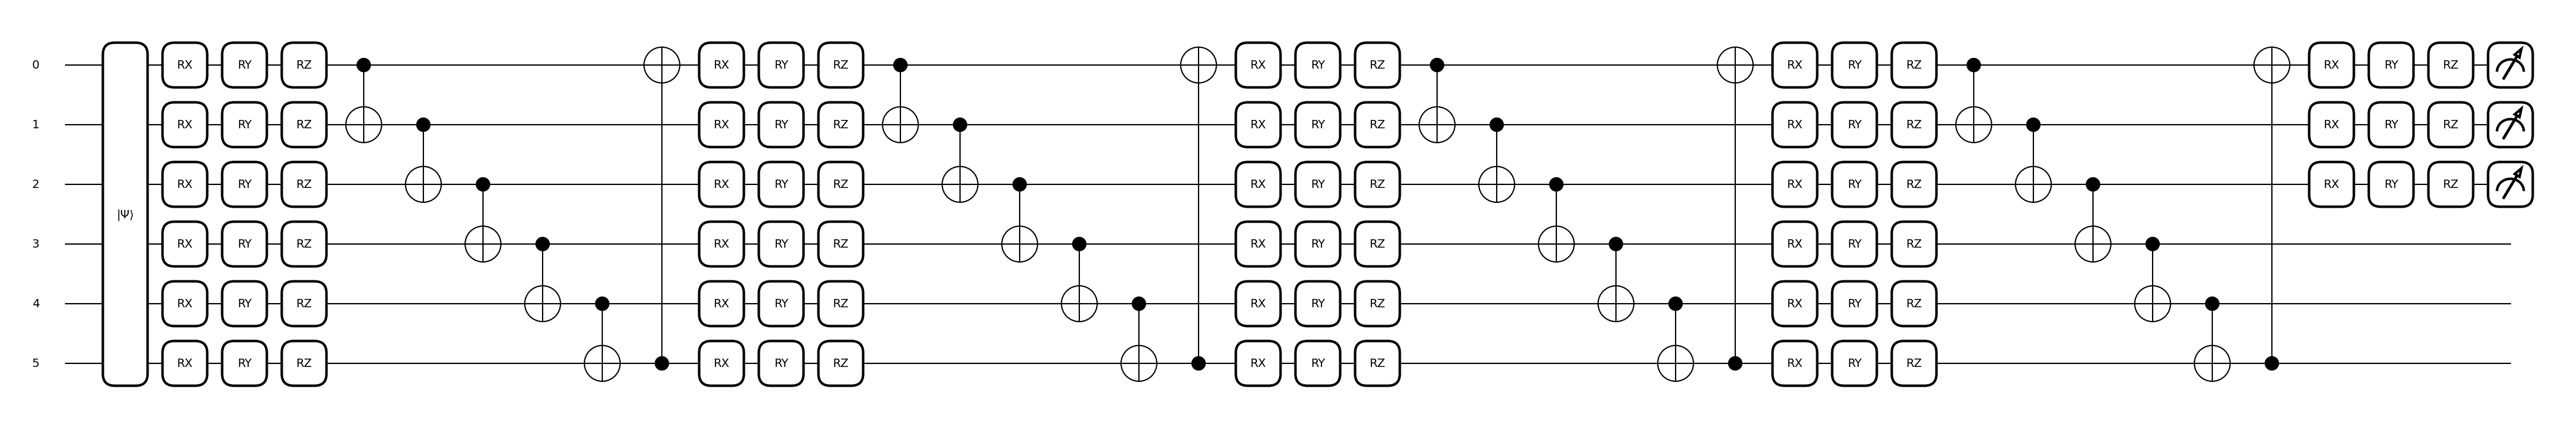

In [ ]:
# visualize the encoder

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(encoder)(params, state, False, n_layers, n_qubits, q_compression)
plt.show()

In [ ]:
# Training hyperparameters
epochs = 10
batch_size = 64
steps_per_epoch = int(train_size/batch_size)
optimizer = torch.optim.Adam([params], lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1 , gamma=0.7)

# dataloader
data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

loss_history = []
params_history = []

# Training Loop
for epoch in range(epochs):
  tot_loss = 0.
  for batch in data_loader:
    optimizer.zero_grad()
    batch = batch.type(torch.float).to(device='cuda:0')
    expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
    loss = expvals[0].mean() + expvals[1].mean() + expvals[2].mean()
    loss.backward()
    optimizer.step()
    tot_loss += loss.cpu().detach().numpy()
  loss_history.append(tot_loss/steps_per_epoch)
  params_history.append(params)
  scheduler.step()
  print("Epoch {}: avg_loss = {}".format(epoch+1, tot_loss/steps_per_epoch))

In [ ]:
# Evaluation of performance on test data

test_set_size = len(normal_data_test)
print("Test set size: ", test_set_size)

normal_data_loader = torch.utils.data.DataLoader(normal_data_test, batch_size=256, shuffle=False, drop_last=False)
anomalous_data_loader = torch.utils.data.DataLoader(anomalous_data_test[0:len(normal_data_test)], batch_size=256, shuffle=False, drop_last=False)
loss_s = np.asarray([])
loss_a = np.asarray([])

with torch.no_grad():
    # Standard data
    for batch in normal_data_loader:
      batch = batch.type(torch.float).to(device='cuda:0')
      expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
      loss = expvals[0].cpu().numpy() + expvals[1].cpu().numpy() + expvals[2].cpu().numpy()
      loss_s = np.concatenate([loss_s,loss])
    # Anomalous dat
    for batch in anomalous_data_loader:
      batch = batch.type(torch.float).to(device='cuda:0')
      expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
      loss = expvals[0].cpu().numpy() + expvals[1].cpu().numpy() + expvals[2].cpu().numpy()
      loss_a = np.concatenate([loss_a,loss])

In [ ]:
# Loss function plot (we use the loss as anomaly score)
plt.hist(loss_a, bins=60, histtype="step", color="red", label="Anomalous data")
plt.hist(loss_s, bins=60, histtype="step", color="blue", label="Normal data")
plt.ylabel("Number of images")
plt.xlabel("Loss value")
plt.title("Loss function distribution (MNIST dataset)")
plt.legend()
#file_plot = "loss_distribution.png"
#plt.savefig(file_plot)
plt.show()
plt.close()

In [ ]:
# Compute and Plot the ROC Curve
max1 = np.amax(loss_s)
max2 = np.amax(loss_a)
ma = max(max1, max2)
min1 = np.amin(loss_s)
min2 = np.amin(loss_a)
mi = min(min1, min2)

tot_neg = len(loss_s)
tot_pos = len(loss_a)

n_step = 100.0
n_step_int = 100
step = (ma - mi) / n_step
fpr = []
tpr = []
for i in range(n_step_int):
    treshold = i * step + mi
    c = 0
    for j in range(tot_neg):
        if loss_s[j] > treshold:
            c += 1
    false_positive = c / float(tot_neg)
    fpr.append(false_positive)
    c = 0
    for j in range(tot_pos):
        if loss_a[j] > treshold:
            c += 1
    true_positive = c / float(tot_pos)
    tpr.append(true_positive)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
#file_plot = "ROC.png"
#plt.savefig(file_plot)
plt.show()
plt.close()

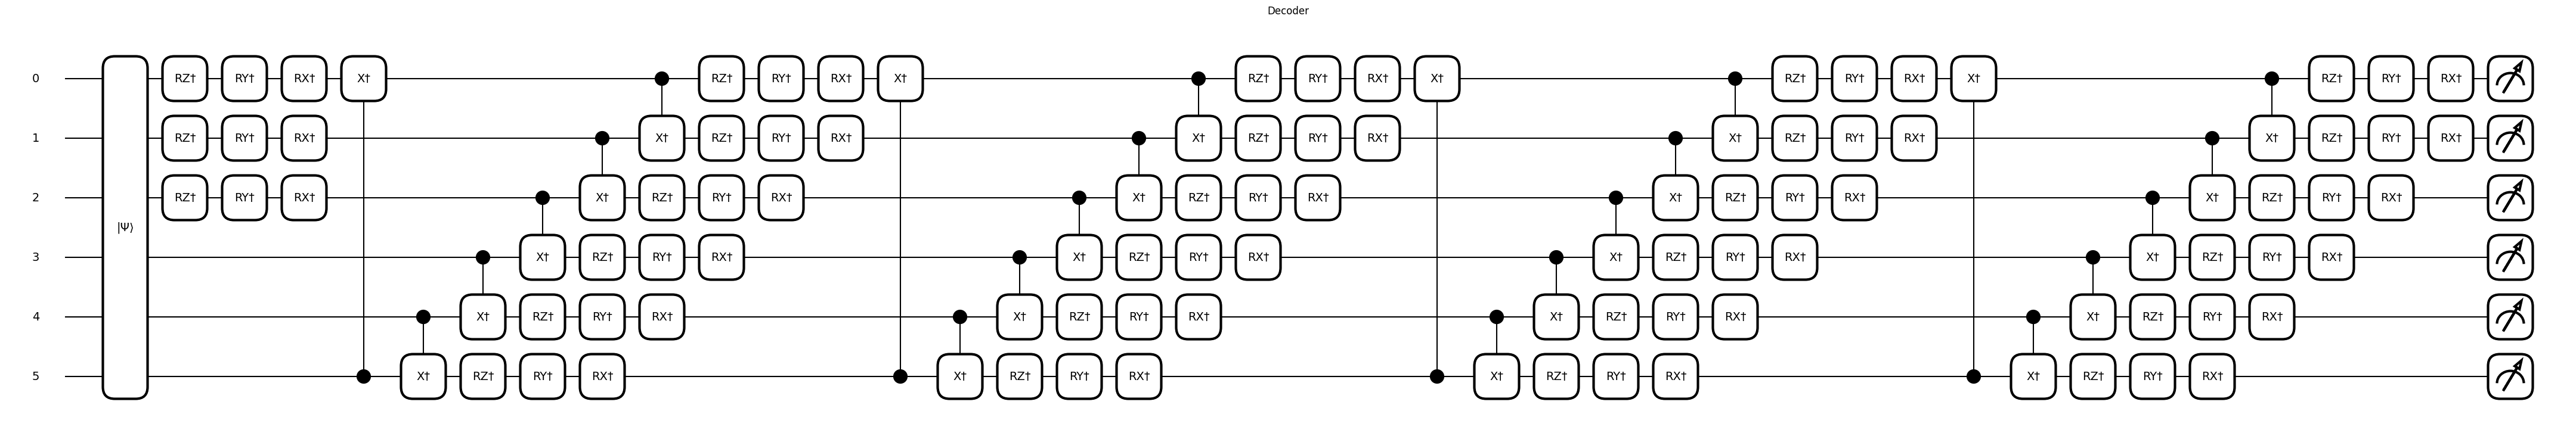

In [ ]:
# Decoder
# we can simply obtain the Decoder as adjoint (eg transpose conjugate) of the encoder unitary

@qml.qnode(dev, interface='torch')
def decoder(params, state, n_layers, n_qubits, q_compression):
    # Prepare initial state
    qml.QubitStateVector(state, wires=range(n_qubits))

    # Real quantum encoding (using amplitude encoding). If you want to use it comment previous line and uncomment this ...
    #qml.AmplitudeEmbedding(features=state, wires=range(n_qubits))


    # Quantum circuit (encoder inverse)
    qml.adjoint(encoder_architecture)(params,  n_layers, n_qubits, q_compression) #qml.adjoint compute the transpose conjugate to an input unitary
    return qml.state()

def prepare_decoder_input(latent_space):
  decoder_input = np.zeros((64,), dtype=complex)
  decoder_input[-len(latent_space):] = latent_space
  # Normalize
  norm = np.linalg.norm(decoder_input)
  decoder_input = decoder_input/norm
  return torch.tensor(decoder_input)

# Visualize_decoder
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(decoder)(params, normal_data_test[0], n_layers, n_qubits, q_compression)
plt.title("Decoder")
plt.show()
plt.close()

In [ ]:
# example on how to use the full outencoder to reconstruct examples

compression = 56 # for 3 out of 6 compressed qubits: compression = 2^5+2^4+2^3
sample = normal_data_test[0] # reconstruct 0
#sample = anomalous_data_test[0] #reconstruct 1
plt.imshow(np.reshape(sample, (8,8)), cmap="gray")
plt.title("Original")
plt.show()
plt.close()
with torch.no_grad():
  final_state = encoder(params=params, state=sample, return_state=True, n_layers=n_layers, n_qubits=n_qubits, q_compression=q_compression).cpu().numpy()
  latent_space = final_state[compression:]
  decoder_input = prepare_decoder_input(latent_space)
  decoder_input = decoder_input.to(device='cuda:0')
  reconstructed = np.absolute(decoder(params, decoder_input, n_layers, n_qubits, q_compression).cpu().numpy())
plt.imshow(np.reshape(reconstructed, (8,8)), cmap="gray")
plt.title("Reconstructed")
plt.show()
plt.close()